# Pruning Experiments on MiniVGG (CIFAR-10)

This notebook investigates the effect of pruning on a MiniVGG model trained on CIFAR-10. We analyze how accuracy (before and after fine-tuning), inference time, and per-class performance evolve with different pruning levels, highlighting the trade-off between model compression, speed, and accuracy.

In [2]:
import copy
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.nn.utils.prune as prune
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import time

## Dataset CIFAR-10

CIFAR-10 is a widely used benchmark dataset for image classification. It consists of 60,000 color images of size 32×32 pixels, divided into 10 classes (airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck). The dataset is split into 50,000 training and 10,000 test images.

In [3]:
tf_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

tf_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=tf_train)
trainloader = DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=tf_test)
testloader = DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

For preprocessing, we apply different transformations to the training and test sets. During training, images are augmented with random cropping (with padding) and horizontal flipping, which increases data diversity and helps the model generalize better. All images are then converted to tensors and normalized channel-wise using the mean and standard deviation of CIFAR-10. For the test set, only conversion and normalization are applied, ensuring that evaluation is consistent while avoiding artificial variability.

## Model

The model used in this experiment is a lightweight variant of the VGG architecture, referred to here as `MiniVGG`. It is composed of three convolutional blocks, each containing two convolutional layers with $3 \times 3$ kernels, followed by batch normalization, ReLU activations, and a max pooling operation that reduces spatial resolution.

This design allows the network to progressively extract more abstract and discriminative features while controlling overfitting through normalization. After the convolutional feature extractor, a fully connected classifier is applied: a dense layer with 512 units, ReLU activation, dropout for regularization, and a final linear layer mapping to the 10 CIFAR-10 classes.

This architecture is chosen because it provides a good balance between representational power and computational efficiency—complex enough to achieve strong performance on CIFAR-10, yet lightweight enough to make pruning experiments meaningful and interpretable.

In [4]:
class MiniVGG(nn.Module):
    def __init__(self):
        super(MiniVGG, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(256*4*4, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, 10)
        )
        
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

## Training

For training, we optimized the MiniVGG model using stochastic gradient descent (SGD) with an initial learning rate of 0.1, momentum of 0.9, and weight decay of $5 \times 10^{-4}$ for regularization. The loss function is cross-entropy, standard for multi-class classification. To improve convergence, we employed a cosine annealing learning rate scheduler, which gradually decreases the learning rate over the training epochs, allowing for both rapid initial learning and fine-grained convergence at later stages. 

After each epoch, the model is evaluated on the test set to monitor performance. We record the training loss, test loss, test accuracy, and current learning rate, which are later visualized to better understand the learning dynamics. This setup ensures stable training and provides a detailed view of how the model improves over time.

Epoch 1/100 | lr=0.10000 | Train Loss=2.232 | Test Loss=2.017 | Acc=18.49%
Epoch 2/100 | lr=0.09998 | Train Loss=1.973 | Test Loss=1.737 | Acc=32.12%
Epoch 3/100 | lr=0.09990 | Train Loss=1.689 | Test Loss=1.524 | Acc=45.42%
Epoch 4/100 | lr=0.09978 | Train Loss=1.352 | Test Loss=1.335 | Acc=52.92%
Epoch 5/100 | lr=0.09961 | Train Loss=1.125 | Test Loss=1.700 | Acc=51.10%
Epoch 6/100 | lr=0.09938 | Train Loss=0.965 | Test Loss=1.053 | Acc=63.93%
Epoch 7/100 | lr=0.09911 | Train Loss=0.873 | Test Loss=1.046 | Acc=65.50%
Epoch 8/100 | lr=0.09880 | Train Loss=0.806 | Test Loss=0.768 | Acc=74.42%
Epoch 9/100 | lr=0.09843 | Train Loss=0.750 | Test Loss=0.957 | Acc=70.05%
Epoch 10/100 | lr=0.09801 | Train Loss=0.704 | Test Loss=0.702 | Acc=75.29%
Epoch 11/100 | lr=0.09755 | Train Loss=0.668 | Test Loss=0.717 | Acc=76.13%
Epoch 12/100 | lr=0.09704 | Train Loss=0.656 | Test Loss=0.893 | Acc=72.05%
Epoch 13/100 | lr=0.09649 | Train Loss=0.623 | Test Loss=0.610 | Acc=79.56%
Epoch 14/100 | lr=0.0

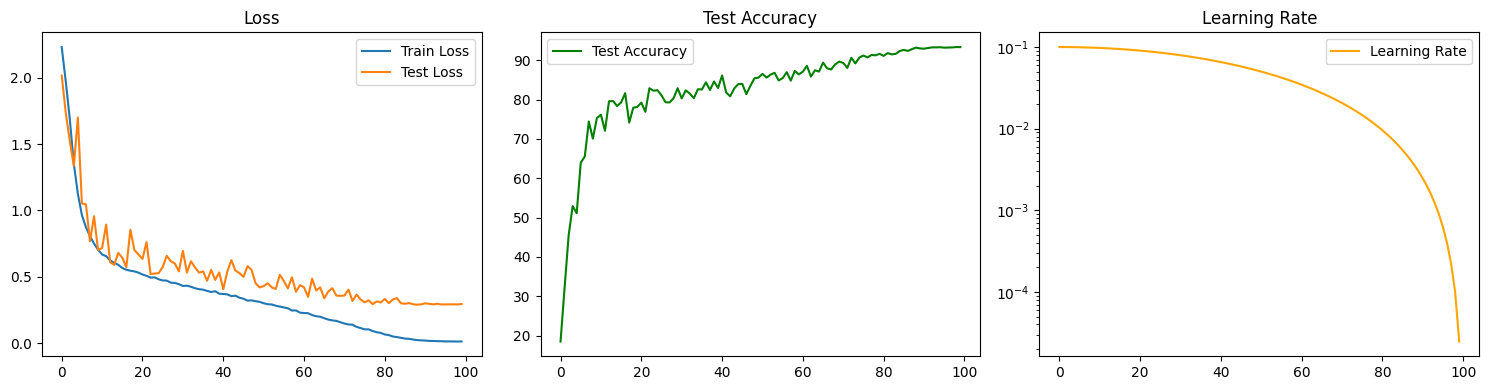

In [5]:
def train_eval(model, device, trainloader, testloader, epochs):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

    train_losses, test_losses, test_accs, learning_rates = [], [], [], []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        train_loss = running_loss / len(trainloader)
        train_losses.append(train_loss)

        # Validation
        model.eval()
        correct, total, test_loss = 0, 0, 0
        with torch.no_grad():
            for inputs, labels in testloader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                test_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        test_loss /= len(testloader)
        acc = 100 * correct / total

        current_lr = scheduler.get_last_lr()[0]
        
        learning_rates.append(current_lr)
        test_losses.append(test_loss)
        test_accs.append(acc)
        scheduler.step()

        print(f"Epoch {epoch+1}/{epochs} | "
          f"lr={current_lr:.5f} | "
          f"Train Loss={train_loss:.3f} | "
          f"Test Loss={test_loss:.3f} | "
          f"Acc={acc:.2f}%")

    return train_losses, test_losses, test_accs, learning_rates, model

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MiniVGG().to(device)

# Training
train_losses, test_losses, test_accs, learning_rates, trained_model = train_eval(model, device, trainloader, testloader, epochs=100)
torch.save(trained_model.state_dict(), "minivgg_cifar10.pth")

# Curves
plt.figure(figsize=(15,4))
plt.subplot(1,3,1); plt.plot(train_losses, label="Train Loss"); plt.plot(test_losses, label="Test Loss")
plt.title("Loss"); plt.legend()
plt.subplot(1,3,2); plt.plot(test_accs, label="Test Accuracy", color="green")
plt.title("Test Accuracy"); plt.legend()
plt.subplot(1,3,3); plt.plot(learning_rates, label="Learning Rate", color="orange")
plt.title("Learning Rate"); plt.yscale("log"); plt.legend()
plt.tight_layout()
plt.show()

The training curves show that the model learns stably and effectively. The training loss decreases smoothly throughout the 100 epochs, indicating steady optimization progress. The test loss follows a similar trend but remains consistently higher than the training loss, which is expected due to generalization error, and it stabilizes after about 50 epochs, suggesting the model has reached a good fit without severe overfitting. 

The test accuracy rises quickly in the early epochs, surpassing 80% within the first 15 epochs, and then improves more gradually to reach above 90%, demonstrating strong performance on CIFAR-10. Finally, the learning rate schedule follows a cosine annealing pattern: it starts high to enable rapid learning, then decays smoothly towards very small values, allowing fine-tuned convergence towards the end of training.

## Benchmark functions

In [8]:
def benchmark(model, device, batch_size=256, n_runs=10):
    model.eval()
    x = torch.randn(batch_size, 3, 32, 32).to(device)
    torch.cuda.synchronize() if device.type == "cuda" else None
    start = time.time()
    with torch.no_grad():
        for _ in range(n_runs):
            _ = model(x)
    torch.cuda.synchronize() if device.type == "cuda" else None
    end = time.time()
    return (end - start) / n_runs

In [20]:
def test(model, device, loader):
    model.eval()
    correct, total = 0, 0
    criterion = nn.CrossEntropyLoss()
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    acc = 100 * correct / total
    return acc

In [31]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def compute_confusion_matrix(model, device, loader, class_names):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    cm = confusion_matrix(all_labels, all_preds, labels=range(len(class_names)))
    return cm

## Pruning

Pruning is a model compression technique where certain weights, neurons, or filters are removed (set to zero) in order to reduce complexity, speed up inference, and potentially lower memory usage. In this experiment, we apply structured pruning to every convolutional and fully connected layer of the MiniVGG model trained on CIFAR-10. We gradually increase the pruning rate (from 0% to 90%) and evaluate the model’s accuracy both before and after a short fine-tuning phase, while also recording inference time and confusion matrices. This allows us to analyze the trade-off between model accuracy and computational efficiency as pruning becomes more aggressive.


=== Pruning amount 0.00 ===
Params=3,249,994 | Acc before FT=93.32% | Acc after FT=93.33% | Inference=17.83 ms

=== Pruning amount 0.05 ===
Params=3,086,393 | Acc before FT=92.67% | Acc after FT=93.22% | Inference=17.45 ms

=== Pruning amount 0.10 ===
Params=2,924,648 | Acc before FT=81.15% | Acc after FT=93.16% | Inference=17.30 ms

=== Pruning amount 0.15 ===
Params=2,763,388 | Acc before FT=69.13% | Acc after FT=93.14% | Inference=17.20 ms

=== Pruning amount 0.20 ===
Params=2,602,155 | Acc before FT=60.98% | Acc after FT=92.72% | Inference=17.19 ms

=== Pruning amount 0.25 ===
Params=2,438,554 | Acc before FT=57.79% | Acc after FT=92.23% | Inference=17.14 ms

=== Pruning amount 0.30 ===
Params=2,274,441 | Acc before FT=33.30% | Acc after FT=92.19% | Inference=17.14 ms

=== Pruning amount 0.35 ===
Params=2,112,696 | Acc before FT=21.27% | Acc after FT=91.30% | Inference=17.01 ms

=== Pruning amount 0.40 ===
Params=1,951,948 | Acc before FT=20.06% | Acc after FT=90.98% | Inference=1

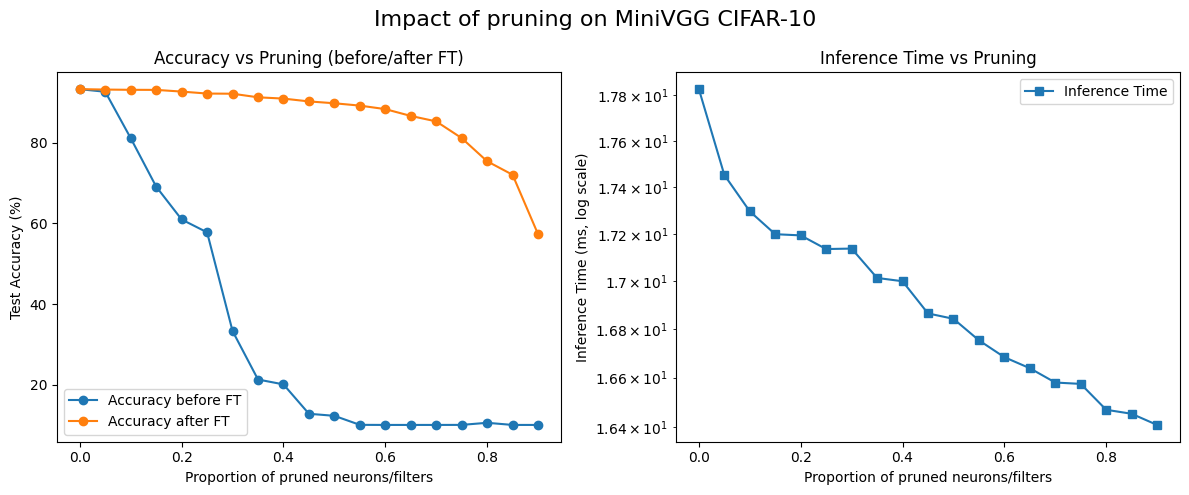

In [50]:
amounts = np.arange(0, 0.95, 0.05) # from 0% to 90%
class_names = trainset.classes

accs_before, accs_after, times, cms = [], [], [], []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
trained_model = MiniVGG().to(device)
trained_model.load_state_dict(torch.load("minivgg_cifar10.pth", map_location=device))

for amount in amounts:
    print(f"\n=== Pruning amount {amount:.2f} ===")
    pruned_model = copy.deepcopy(trained_model)

    # Structured pruning on all layers Conv and Linear
    for name, module in pruned_model.named_modules():
        if isinstance(module, nn.Conv2d) or isinstance(module, nn.Linear):
            prune.ln_structured(module, name="weight", amount=amount, n=2, dim=0)
            prune.remove(module, "weight")

    # Amount of remaining parameters
    n_params = sum(torch.count_nonzero(p).item() for p in pruned_model.parameters())

    # --- Accuracy before fine-tuning ---
    acc_before = test(pruned_model, device, testloader)

    # --- Quick Fine-tuning ---
    optimizer = optim.SGD(pruned_model.parameters(), lr=1e-3, momentum=0.9, weight_decay=5e-4)
    pruned_model.train()
    for epoch in range(10):  # quelques epochs suffisent
        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = pruned_model(inputs)
            loss = F.cross_entropy(outputs, labels)
            loss.backward()
            optimizer.step()

    # --- Accuracy after fine-tuning ---
    acc_after = test(pruned_model, device, testloader)

    # --- Compute confusion matrix ---
    cm = compute_confusion_matrix(pruned_model, device, testloader, class_names)
    cms.append(cm)

    # --- Inference Time ---
    t_inf = benchmark(pruned_model, device)

    accs_before.append(acc_before)
    accs_after.append(acc_after)
    times.append(t_inf)

    print(f"Params={n_params:,} | Acc before FT={acc_before:.2f}% | "
          f"Acc after FT={acc_after:.2f}% | Inference={t_inf*1000:.2f} ms")

# -----------------------------
# Curves trade-off
# -----------------------------

fig, axes = plt.subplots(1, 2, figsize=(12,5))

# Plot 1 : Accuracy before/after FT
axes[0].plot(amounts, accs_before, marker="o", label="Accuracy before FT")
axes[0].plot(amounts, accs_after, marker="o", label="Accuracy after FT")
axes[0].set_xlabel("Proportion of pruned neurons/filters")
axes[0].set_ylabel("Test Accuracy (%)")
axes[0].set_title("Accuracy vs Pruning (before/after FT)")
axes[0].legend()

# Plot 2 : Inference Time (log scale)
axes[1].plot(amounts, [t*1000 for t in times], marker="s", label="Inference Time")
axes[1].set_xlabel("Proportion of pruned neurons/filters")
axes[1].set_ylabel("Inference Time (ms, log scale)")
axes[1].set_yscale("log")
axes[1].set_title("Inference Time vs Pruning")
axes[1].legend()

fig.suptitle("Impact of pruning on MiniVGG CIFAR-10", fontsize=16)

plt.tight_layout()
plt.savefig("pruning.png")
plt.show()

This pruning experiment highlights the balance between compression and accuracy. Without fine-tuning, pruning quickly degrades performance, with accuracy collapsing even at moderate pruning rates. However, after fine-tuning, the model shows strong resilience: up to around 70% of neurons/filters can be pruned while maintaining near-baseline accuracy. Only at extreme pruning levels does the performance drop significantly, reflecting the limits of the model’s redundancy.

In terms of efficiency, pruning leads to a steady reduction in inference time, although the gains remain modest because masked weights are not physically removed from the architecture. To achieve larger speedups, structural reparameterization or dedicated pruning libraries would be required. Overall, the study demonstrates that structured pruning combined with fine-tuning is an effective strategy to compress neural networks while preserving much of their predictive power, providing an insightful illustration of the accuracy–efficiency trade-off in deep learning.

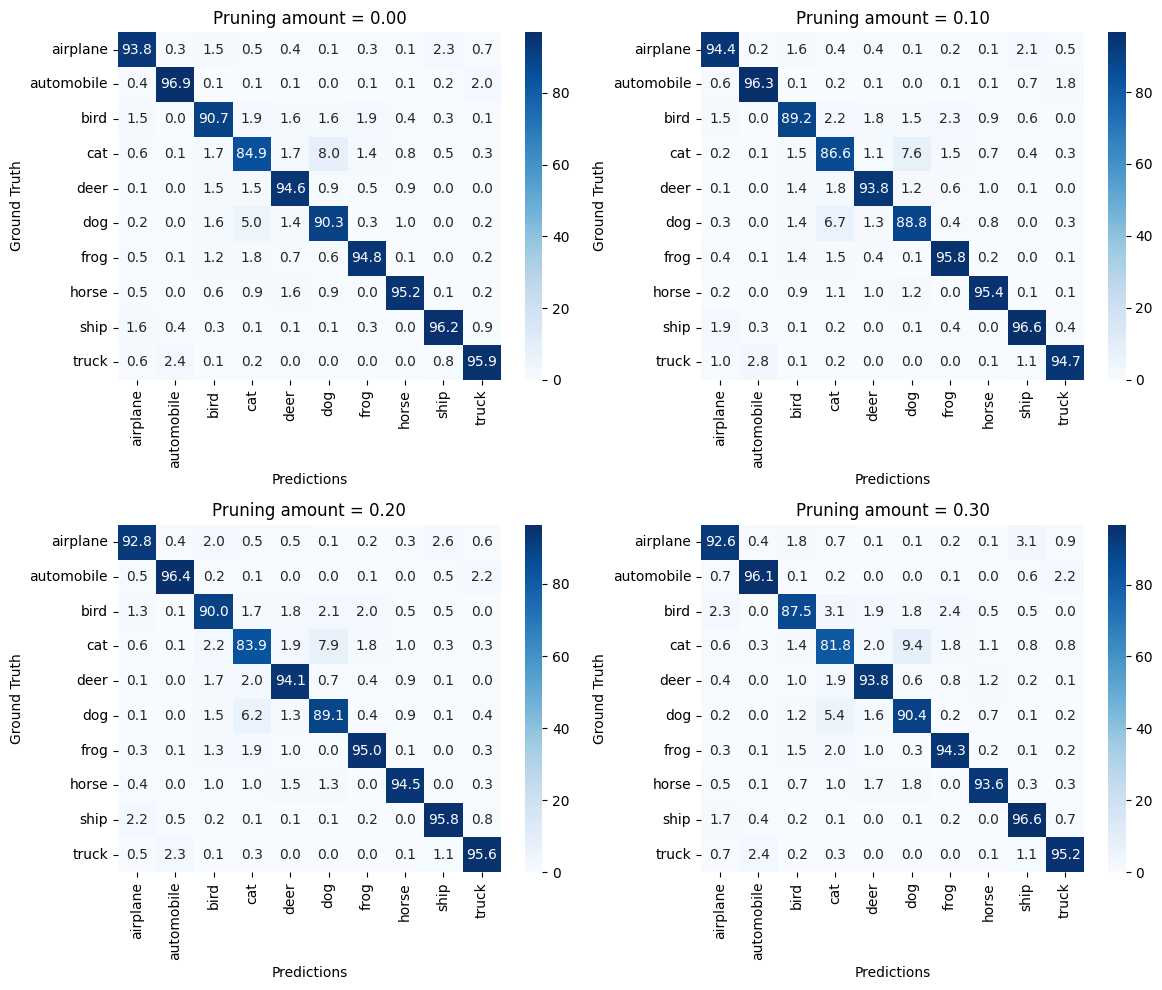

In [56]:
selected_indices = [0, 2, 4, 6]
selected_amounts_cm = [0.0, 0.1, 0.2, 0.3]

fig, axes = plt.subplots(2, 2, figsize=(12,10))

for ax, idx, amount in zip(axes.flat, selected_indices, selected_amounts_cm):
    cm = cms[idx]
    cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] * 100
    sns.heatmap(cm_norm, annot=True, fmt=".1f", cmap="Blues", ax=ax, xticklabels=class_names, yticklabels=class_names)
    ax.set_title(f"Pruning amount = {amount:.2f}")
    ax.set_xlabel("Predictions")
    ax.set_ylabel("Ground Truth")

plt.tight_layout()
plt.savefig("confusion_matrix.png")
plt.show()


The confusion matrices show that at 0% pruning, the model performs very well across all classes, with per-class accuracies mostly above 90%. As pruning increases, the performance remains stable for several categories such as *ship*, *automobile*, and *truck*, which stay above ~95% even at 30% pruning. This indicates that these classes are easier to distinguish and more robust to model compression.

By contrast, classes like *cat*, *dog*, and *bird* exhibit a sharper decline in accuracy as pruning grows: for example, *cat* drops from ~85% at 0% pruning to ~81.8% at 30%, while *bird* falls from ~90.7% to ~87.5%. These classes are more visually similar to others and thus more sensitive to reduced model capacity. Overall, the confusion matrices confirm that pruning does not impact all classes equally: robust classes retain high accuracy, whereas ambiguous ones degrade earlier, highlighting the heterogeneous effect of pruning across categories.

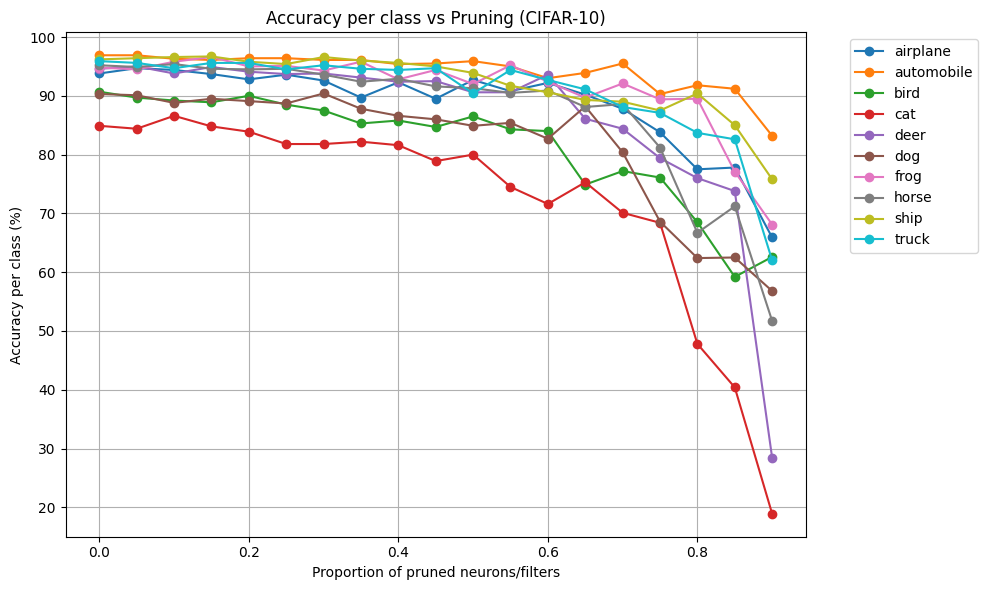

In [61]:
per_class_accs = []
for cm in cms:
    accs = cm.diagonal() / cm.sum(axis=1)
    per_class_accs.append(accs)

per_class_accs = np.array(per_class_accs)  # shape (len(cms), nb_classes)

plt.figure(figsize=(10,6))
for i, cname in enumerate(class_names):
    plt.plot(amounts, per_class_accs[:, i] * 100, marker="o", label=cname)
    
plt.xlabel("Proportion of pruned neurons/filters")
plt.ylabel("Accuracy per class (%)")
plt.title("Accuracy per class vs Pruning (CIFAR-10)")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(True)
plt.tight_layout()
plt.savefig("accuracy_per_class.png")
plt.show()

The per-class curves show that some categories, like *automobile*, *ship*, and *truck*, remain robust to pruning, keeping accuracies close to 90% until very high pruning levels. In contrast, more ambiguous classes such as *cat*, *dog*, and *bird* degrade much earlier, with *cat* dropping below 60% at ~70% pruning.

This highlights that pruning does not impact all classes equally: while overall accuracy can remain high after fine-tuning, certain categories become disproportionately vulnerable, which is important to consider for balanced performance across tasks.

## Conclusion

Through these experiments, we showed that structured pruning, combined with fine-tuning, can significantly reduce the number of active parameters in a CNN while preserving strong performance on CIFAR-10. Up to ~70% pruning, the MiniVGG model maintains near-baseline accuracy after fine-tuning, while inference time decreases steadily, illustrating the trade-off between compression and efficiency.

However, the analysis also revealed important nuances: certain classes such as *cat* or *dog* are far more sensitive to pruning than robust ones like *automobile* or *ship*; and speed gains remain modest since pruning does not physically shrink the architecture. Overall, pruning is a powerful tool for model compression, but its impact is uneven across tasks and requires careful calibration to balance efficiency with reliable accuracy.